# Review of Statistics

This notebook shows some basic statistics needed for this course.

It uses the `Statistics` package (built in) for descriptive statistics (averages, autocorrelations, etc) and the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl)  package for statistical distributions (pdf, cdf, etc).

## Load Packages and Extra Functions

In [1]:
using Printf, Statistics, LinearAlgebra, DelimitedFiles, Distributions

include("src/OlsGMFn.jl")
include("src/printmat.jl");

In [2]:
using Plots, LaTeXStrings             #packages for plotting and LaTeX
default(size = (480,320),fmt = :png)  #or :svg

# Distributions

## Probability Density Function (pdf)

The cells below calculate and plot pdfs and cdfs of some distributions often used in the lecture notes. The `Distributions.jl` package has many more distributions.

### A Remark on the Code

- Notice that the `Distributions.jl` package wants `Normal(μ,σ)`, where `σ` is the standard deviation. However, the notation in the lecture notes is $N(\mu,\sigma^2)$. For instance, $N(0,2)$ from the lectures is coded as `Normal(0,sqrt(2))`.
- `pdf.(Normal(0,1),x)` calculates the pdf of a standard normal variable at each value in the array `x`. Notice the dot (`.`).

Pr(x<=0.5)      0.691


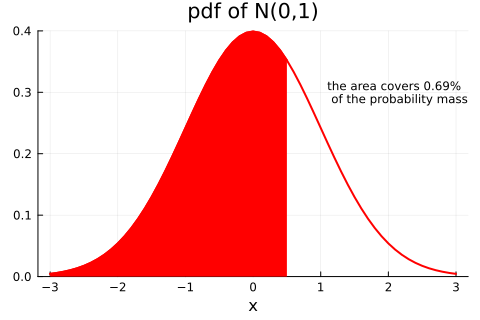

In [3]:
x  = -3:0.1:3
xb = x[x.<=0.5]                  #pick out x values <= 0.5

pdfx  = pdf.(Normal(0,1),x)       #calculate the pdf of a N(0,1) variable
pdfxb = pdf.(Normal(0,1),xb)      #colour the area below this curve
Prb = cdf(Normal(0,1),0.5)
printlnPs("Pr(x<=0.5) ",Prb)

p1 = plot( x,pdfx,                        #plot pdf
           linecolor = :red,
           linewidth = 2,
           legend = nothing,
           ylims = (0,0.4),
           title = "pdf of N(0,1)",
           xlabel = "x",
           annotation = (1.1,0.3,text("the area covers $(round(Prb,digits=2))%\n of the probability mass",:left,8)) )
plot!(xb,pdfxb,linecolor=:red,linewidth=2,legend=nothing,fill=(0,:red))    #plot area under pdf
display(p1)

In [4]:
printlnPs("5% quantile of N(0,1): ", quantile(Normal(0,1),0.05))

5% quantile of N(0,1):     -1.645


## Expected Values and Variances

The random variable used in the example below can only take two values in the vector `x = [x₁,x₂]`, with probabilities in `p = [p₁,1-p₁]`.   (`π` is already defined in one of the packages.)

In [5]:
x = [9.5,11]
p = [0.4,0.6]

μ = sum(p.*x)               #or `dot(π,x)`
printlnPs("μ: ",μ)

σ² =  dot(p,(x.-μ).^2)  
printlnPs("σ²: ",σ²)

printlnPs("\nCheck the variance against the theoretical result:", p[1]*p[2]*(x[2]-x[1])^2)

       μ:     10.400
      σ²:      0.540

Check the variance against the theoretical result:     0.540


## Expected Value of a function and Its Derivative

In [6]:
Elnx = dot(p,log.(x))     #expected value of log(x)
println("log(x) and its expected value")
Edlnx = dot(p,1.0./x)      #derivative of log(x) is 1/x

xut = hcat([x;μ],[log.(x);Elnx],[1.0./x;Edlnx])
printmat(xut;rowNames=["state 1","state 2","expected value"],colNames=["x","log(x)","dlog(x)/dx"],width=12)

log(x) and its expected value
                         x      log(x)  dlog(x)/dx
state 1              9.500       2.251       0.105
state 2             11.000       2.398       0.091
expected value      10.400       2.339       0.097



# Expected Value and Variance of Linear Combinations

In [7]:
μ = [11.5, 9.5, 6]/100          #expected returns for 3 assets
Σ = [166  34  58;               #covariance matrix
      34  64   4;
      58   4 100]/100^2
Rf = 0.03                       #riskfree return

0.03

In [8]:
w = [0.25,0.68,0.07]      #portfolio weights summing to 1

3-element Vector{Float64}:
 0.25
 0.68
 0.07

In [9]:
ERp = dot(w,μ)
VarRp = w'*Σ*w;          #or dot(w,Σ,w)

0.005442940000000001

In [10]:
xut = [ERp,VarRp,sqrt(VarRp)]
printmat(xut;rowNames=["mean","variance","std"])

mean         0.098
variance     0.005
std          0.074



# Linear Regressions

using the included function `OlsGMFn(Y,X)` where `Y`

In [11]:
x = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)

                #yearmonth, market, small minus big, high minus low
(ym,Rme,RSMB,RHML) = (x[:,1],x[:,2]/100,x[:,3]/100,x[:,4]/100)
x = nothing

printlnPs("Sample size:",size(Rme))

Sample size:    (388,)


In [12]:
Y = Rme                    #T-vector, to get standard OLS notation
T = size(Y,1)              
X = [ones(T) RSMB RHML]    #TxK matrix, regressors

(b,_,_,V,R²) = OlsGMFn(Y,X)
Stdb = sqrt.(diag(V))        #standard errors, assuming iid errors

printblue("OLS Results:\n")
xNames = ["c","SMB","HML"]
printmat(b,Stdb,colNames=["b","std"],rowNames=xNames)

printlnPs("R²: ",R²)

OLS Results:

            b       std
c       0.007     0.002
SMB     0.217     0.073
HML    -0.429     0.074

      R²:      0.134


## Test a Single Coefficient

Suppose we want to test if the 2nd coefficient os equal to 0.3 THis can be done as follows. 
If the |t-stat|, is larger than 1.645, then you cannot reject the null hypothesis on the 10% significance level

In [13]:
t = (b[2]-0.3)/Stdb[2]

printlnPs("|t| : ",abs(t))    
    

    |t| :      1.132


## Test Several coefficients

or some linear combinations of them, then 

Since the estimator $\hat{\beta}_{_{k\times1}}$ satisfies

$\hat{\beta}-\beta_{0} \sim N(0,V_{k\times k}),$

we can easily apply various tests. Consider a joint linear hypothesis of the
form

$H_0: R\beta=q,$

where $R$ is a $J \times k$ matrix and $q$ is a $J$-vector. To test this, use

$(R\beta-q)^{\prime}(RVR^{\prime}) ^{-1}(R\beta
-q)\overset{d}{\rightarrow}\chi_{J}^{2}.$


In [14]:
R = [0 1 0;
     0 0 1]
q = [0.3;0]               #β[2]=0.3 and β[3]=0

2-element Vector{Float64}:
 0.3
 0.0

In [15]:
Q = (R*b-q)'*inv(R*V*R')*(R*b-q)

printlnPs("Compare with 10% critical value of Χ^2(2): ",Q," ",quantile(Chisq(2),0.9))

Compare with 10% critical value of Χ^2(2):     34.669               4.605
